#### Update content of the CPM Atlas - generate maps for past performance page<br>
Author          : Team BETA<br>
Return Values   : png files<br>
Source data     : The data is preprocessed and provided by Petter Lind.

In [1]:
import xarray as xr
from pathlib import Path
from itertools import product
import xesmf as xe
# for clipping
import rioxarray

In [2]:
# path to datasets
path_data = "/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind"

In [3]:
# get the observation data
obs_data_pr = xr.open_dataset(Path(path_data, "OBS", "EOBS20_seasonal_cycle_pr_day_mean_native_grid_1980-2010_ANN.nc"))
obs_data_pr

<xarray.Dataset>
Dimensions:  (season: 4, lat: 465, lon: 705)
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * lon      (lon) float64 -24.95 -24.85 -24.75 -24.65 ... 45.25 45.35 45.45
  * lat      (lat) float64 25.05 25.15 25.25 25.35 ... 71.15 71.25 71.35 71.45
Data variables:
    pr       (season, lat, lon) float64 ...
Attributes:
    Description:    Seasonal cycle | Season stat: mean | Threshold: None
    Analysed time:  1980-2010 | ANN

In [4]:
# load all relevant datasets and plot maps
seasons = ['DJF', 'JJA']
variables = ['tas', 'pr']
projects = ["CPM", "RCM", "GCM"]

for project, variable in product(projects, variables):
    directory = path_data + f"/{project}/{variable}"
    for ncfile in Path(directory).iterdir():
        # filter the historical runs
        if "his" in str():
            
        if project == "GCM":
            region, group, model, _, season = ncfile.stem.split('_')[]
        else:

        print(ncfile)


/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cclm_ec-earth_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc
/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cclm_ec-earth_rcp85_seasonal_cycle_tas_D_mean_mean_native_grid_2041-2050_ANN.nc
/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cnrm-arome_cnrm-cm5_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc
/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_cnrm-arome_cnrm-cm5_rcp85_seasonal_cycle_tas_D_mean_mean_native_grid_2041-2050_ANN.nc
/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_ethz-cclm_mpi_his_seasonal_cycle_tas_D_mean_mean_native_grid_1996-2005_ANN.nc
/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_ethz-cclm_mpi_rcp85_seasonal_cycle_tas_D_mean_mean_native_grid_2041-2050_ANN.nc
/mnt/d/NLeSC/BETA/EUCP/Data_Catalogue/data_Petter_Lind/CPM/tas/alp-3_ethz-cclm_mpi_rcp85_seasonal_cy

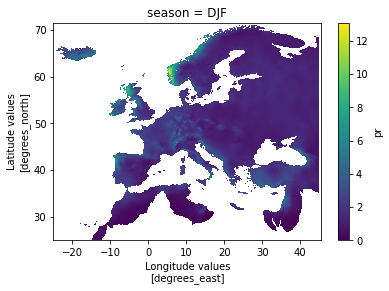

In [4]:
obs_data.pr.sel(season="DJF").plot()

In [5]:
cpm_data = xr.open_dataset(Path(path_data, "CPM", "daily_seasonal_cycle",
    "alp-3_cclm_ec-earth_his_seasonal_cycle_pr_D_sum_mean_native_grid_1996-2005_ANN.nc"))
cpm_data

<xarray.Dataset>
Dimensions:  (season: 4, rlat: 444, rlon: 476)
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
    lon      (rlat, rlon) float64 ...
    lat      (rlat, rlon) float64 ...
  * rlon     (rlon) float64 -13.51 -13.48 -13.46 ... -0.5038 -0.4762 -0.4487
  * rlat     (rlat) float64 -10.93 -10.9 -10.88 -10.85 ... 1.196 1.224 1.251
Data variables:
    pr       (season, rlat, rlon) float32 ...
Attributes:
    Description:    Seasonal cycle | Season stat: mean | Threshold: None
    Analysed time:  1996-2005 | ANN

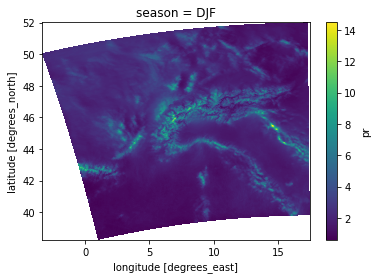

In [24]:
cpm_data.pr.sel(season="DJF").plot(x="lon", y="lat")
import numpy as np
cpm_data['mask'] = xr.where(~np.isnan(cpm_data.pr.sel(season="DJF")), 1, 0)
obs_data['mask'] = xr.where(~np.isnan(obs_data.pr.sel(season="DJF")), 1, 0)

In [25]:
regridder = xe.Regridder(cpm_data, obs_data, "bilinear")
dr_out = regridder(cpm_data.pr)

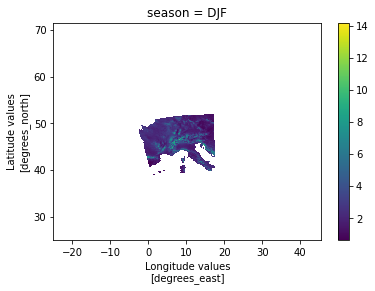

In [29]:
dr_out.sel(season="DJF").plot()

In [30]:
pr_diff = dr_out - obs_data.pr

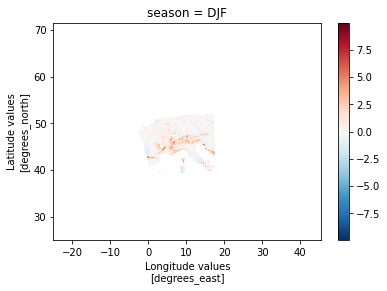

In [31]:
pr_diff.sel(season="DJF").plot()

In [10]:
rcm_data = xr.open_dataset(Path(path_data, "RCM", "daily_seasonal_cycle",
    "alp-12_hclim_ec-earth_his_seasonal_cycle_pr_D_sum_mean_native_grid_1996-2005_ANN.nc"))
rcm_data

<xarray.Dataset>
Dimensions:  (season: 4, y: 273, x: 297)
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
  * x        (x) float64 1.08e+05 1.2e+05 1.32e+05 ... 3.648e+06 3.66e+06
  * y        (y) float64 1.08e+05 1.2e+05 1.32e+05 ... 3.36e+06 3.372e+06
Data variables:
    pr       (season, y, x) float64 ...
Attributes:
    Description:    Seasonal cycle | Season stat: mean | Threshold: None
    Analysed time:  1996-2005 | ANN

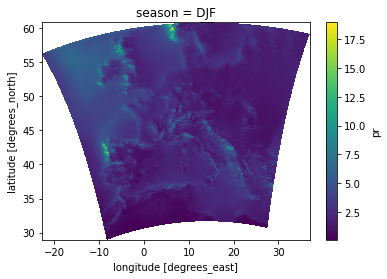

In [12]:
rcm_data.pr.sel(season="DJF").plot(x="lon", y="lat")
#rcm_data.pr.sel(season="DJF").plot()

In [13]:
gcm_data = xr.open_dataset(Path(path_data, "GCM", "daily_seasonal_cycle",
    "cnrm_cnrm-cm5_his_seasonal_cycle_pr_day_mean_native_grid_1996-2005_ANN.nc"))
gcm_data

<xarray.Dataset>
Dimensions:   (season: 4, lat: 128, bnds: 2, lon: 256)
Coordinates:
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * lat       (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon       (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (season, lat, bnds) float64 ...
    lon_bnds  (season, lon, bnds) float64 ...
    pr        (season, lat, lon) float64 ...
Attributes:
    Description:    Seasonal cycle | Season stat: mean | Threshold: None
    Analysed time:  1996-2005 | ANN

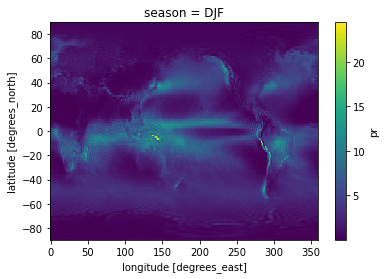

In [14]:
gcm_data.pr.sel(season="DJF").plot()